# GRB 050724

In this jupyter notebook we look at analyzing TTE data associated with the BAT triggered GRB 050724, a short GRB with extended emission. The GCN for this event can be found [here](https://gcn.nasa.gov/circulars/3665?query=GRB050724&startDate=&endDate=&sort=relevance). The BAT refined circular can be found [here](https://gcn.nasa.gov/circulars/3667?query=GRB050724&startDate=&endDate=&sort=relevance) with the relevant data analyzed by the BAT team [https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/web/GRB050724.html](https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/web/GRB050724.html)

Lets first import all the packages that we need.

In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO, ObsQuery, Clock
import swiftbat

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os

We will also setup our data directory to hold the data and the results of our analysis. 

In [2]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)


PosixPath('/private/tmp/batdata/download_examples')

We will now query the data for this GRB. There are many ways to do this in the [swifttools](https://www.swift.psu.edu/too_api/index.php?md=Swift_Data%20Example%20Notebook.ipynb) package such as querying based on time, observation ID, etc but here we will use the target ID for this GRB. The target id for GRBs is the trigger number which is provided in the GCN that we linked above. 

In [3]:
query = ObsQuery(targetid=147478)
query

2005-07-24 12:34:18,2005-07-24 13:13:12,GRB050724,00147478000,2270,64
2005-07-24 14:04:29,2005-07-24 14:49:29,GRB050724,00147478000,2561,139
2005-07-24 15:40:54,2005-07-24 16:25:54,GRB050724,00147478000,2561,139
2005-07-24 17:17:19,2005-07-24 18:02:19,GRB050724,00147478000,2572,128
2005-07-24 18:53:45,2005-07-24 19:38:45,GRB050724,00147478000,2573,127
2005-07-24 20:31:03,2005-07-24 21:15:20,GRB050724,00147478000,2530,127
2005-07-24 22:06:36,2005-07-24 22:51:36,GRB050724,00147478000,2583,117
2005-07-24 23:43:02,2005-07-25 00:28:02,GRB050724,00147478000,2583,117
2005-07-25 01:19:27,2005-07-25 02:04:27,GRB050724,00147478000,2636,64
2005-07-25 02:55:53,2005-07-25 03:40:53,GRB050724,00147478000,2636,64
2005-07-25 04:32:19,2005-07-25 05:17:19,GRB050724,00147478000,2636,64


In this next cell we show how we can query the data associated with this GRB by name. We can see that many observation IDs pop up, all with the target id but the last digit of the number incremented. This is indicative of the observations that were taken for this GRB, where 000 indicated the initial BAT triggered observation and subsequent number 001-009 indicate the afterglow followup. For our analysis of the BAT triggered TTE data, we want the observation ending in 000.

In [4]:
query = ObsQuery(name="GRB050724")
query

2005-07-24 12:34:18,2005-07-24 13:13:12,GRB050724,00147478000,2270,64
2005-07-24 14:04:29,2005-07-24 14:49:29,GRB050724,00147478000,2561,139
2005-07-24 15:40:54,2005-07-24 16:25:54,GRB050724,00147478000,2561,139
2005-07-24 17:17:19,2005-07-24 18:02:19,GRB050724,00147478000,2572,128
2005-07-24 18:53:45,2005-07-24 19:38:45,GRB050724,00147478000,2573,127
2005-07-24 20:31:03,2005-07-24 21:15:20,GRB050724,00147478000,2530,127
2005-07-24 22:06:36,2005-07-24 22:51:36,GRB050724,00147478000,2583,117
2005-07-24 23:43:02,2005-07-25 00:28:02,GRB050724,00147478000,2583,117
2005-07-25 01:19:27,2005-07-25 02:04:27,GRB050724,00147478000,2636,64
2005-07-25 02:55:53,2005-07-25 03:40:53,GRB050724,00147478000,2636,64
2005-07-25 04:32:19,2005-07-25 05:17:19,GRB050724,00147478000,2636,64


Lets download this first observation which was produced by BAT triggering on the GRB. 

In [5]:
download = ba.download_swiftdata(observations=query[0].obsid)
print(download)

{'00147478000': {'obsid': '00147478000', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/00147478000'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='00147478000',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}


/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: SWIFT_TLE_ARCHIVE.txt.14335.67560079.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00147478000pat.fits.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00147478000pjb.par.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00147478000pob.cat.gz exists and not overwritten (set clobber=True to override this).
/Users/tparsota/miniforge3/lib/python3.12/site-packages/swifttools/swift_too/swift_data.py:394: UserWarning: sw00147478000ppr.par.gz exists and not overwritten (set clobber=True to override this)

Lets now load it into a `BatEvent` object which will ensure that the energy calibration is completed and that the mask weighting is done for the GRB coordinates that were obtained by BAT when this GRB triggered the instrument. 

In [6]:
event=ba.BatEvent(query[0].obsid)

A save file has been written to /private/tmp/batdata/download_examples/00147478000_eventresult/batevent.pickle.


Now we can easily plot the lightcurve of the GRB around the time of trigger. This looks like a typical Short GRB. This picture will change when we rebin this GRB's lightcurve using bayesian blocks.

(-1.0, 1.0)

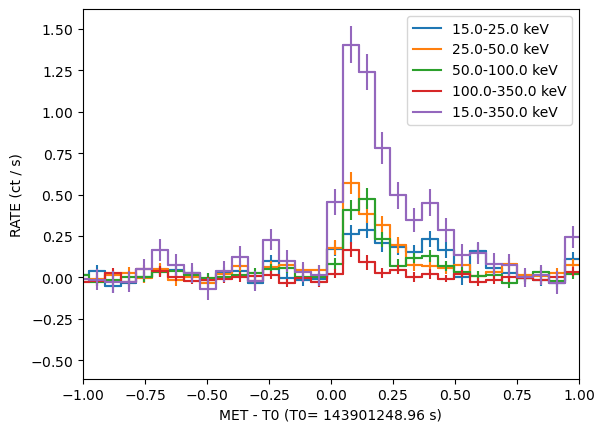

In [7]:
lc=event.create_lightcurve()
fig, ax =lc.plot(T0=event.trigtime.met, plot_relative=True)
ax.set_xlim([-1, 1])


We can easily rebin the lightcurve that we created using a bayesian blocks algorithm and also measure various durations such as $T_{90}$. This is done in the next block. 

The durations that are measured will be critical for constructing spectra at these different intervals later on. 

In [8]:
lc.set_timebins(timebinalg="bayesian", save_durations=True)

In [9]:
print(f"The measured T90 is {lc.tdurs['T90']['TSTOP']-lc.tdurs['T90']['TSTART']}\nmeasured from {lc.tdurs['T90']['TSTART']-event.trigtime.met*u.s}-{lc.tdurs['T90']['TSTOP']-event.trigtime.met*u.s}" )
print(f"The measured {lc.tdurs['PEAK']['TSTOP']-lc.tdurs['PEAK']['TSTART']} peak is \nmeasured from {lc.tdurs['PEAK']['TSTART']-event.trigtime.met*u.s}-{lc.tdurs['PEAK']['TSTOP']-event.trigtime.met*u.s}" )
print(f"The measured T100 is {lc.tdurs['TOT']['TSTOP']-lc.tdurs['TOT']['TSTART']}\nmeasured from {lc.tdurs['TOT']['TSTART']-event.trigtime.met*u.s}-{lc.tdurs['TOT']['TSTOP']-event.trigtime.met*u.s}" )

print("The bayesian block timebins are:")
for i,j in zip(lc.tbins['TIME_START'], lc.tbins['TIME_STOP']):
    print(i.value, j.value)

The measured T90 is 99.26400002837181 s
measured from 0.04799997806549072 s-99.3120000064373 s
The measured 1.0 s peak is 
measured from -0.06799998879432678 s-0.9320000112056732 s
The measured T100 is 107.19999998807907 s
measured from -0.01600000262260437 s-107.18399998545647 s
The bayesian block timebins are:
143900950.0 143901248.944
143901248.944 143901249.00800002
143901249.008 143901249.136
143901249.136 143901249.456
143901249.456 143901251.696
143901251.69600004 143901356.144
143901356.144 143901552.11200005


Now we can plot the bayesian binned lightcurve. We can clearly see the extended emission that lasts for ~100 seconds, contributing to the measured $T_{90}$ being so large while the initial pulse is significantly shorter. 

Comparing this lightcurve to the GRB catalog that was linked above shows the agreement between BatAnalysis and the analyses done by the BAT team in the past. 

{'T90': {'TSTART': <Quantity 1.43901249e+08 s>, 'TSTOP': <Quantity 1.43901348e+08 s>}, 'T50': {'TSTART': <Quantity 1.43901251e+08 s>, 'TSTOP': <Quantity 1.43901326e+08 s>}, 'PEAK': {'TSTART': <Quantity 1.43901249e+08 s>, 'TSTOP': <Quantity 1.4390125e+08 s>}, 'TOT': {'TSTART': <Quantity 1.43901249e+08 s>, 'TSTOP': <Quantity 1.43901356e+08 s>}, 'BKG1': {'TSTART': <Quantity -1.e+307 s>, 'TSTOP': <Quantity 1.43901249e+08 s>}, 'BKG2': {'TSTART': <Quantity 1.43901356e+08 s>, 'TSTOP': <Quantity 1.e+307 s>}}
{'TIME_CENT': <Quantity [1.43901099e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901251e+08, 1.43901304e+08, 1.43901454e+08] s>, 'TIME_START': <Quantity [1.43900950e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901249e+08, 1.43901252e+08, 1.43901356e+08] s>, 'TIME_STOP': <Quantity [1.43901249e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901252e+08, 1.43901356e+08, 1.43901552e+08] s>}


(0.0, 150.0)

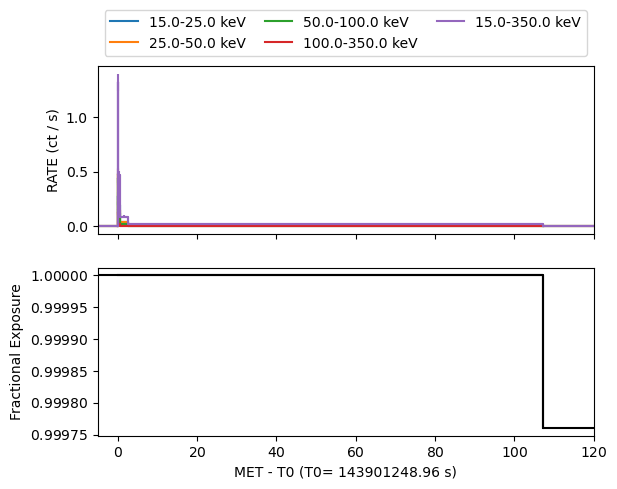

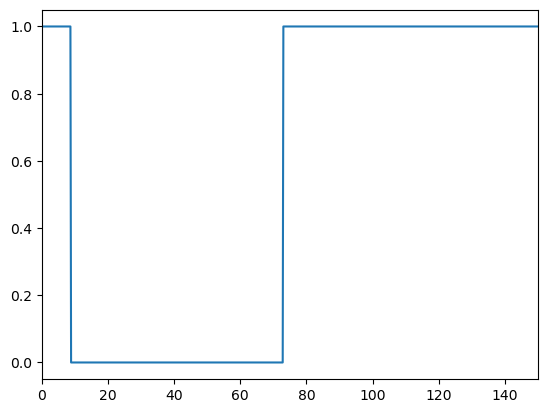

In [10]:
fig, ax = lc.plot(T0=event.trigtime.met, plot_relative=True, plot_exposure_fraction=True)
ax[0].set_xlim([-5, +120])
print(lc.tdurs)
print(lc.tbins)

fig, axis = plt.subplots(1)
axis.plot(event.attitude.time.value - event.trigtime.met, event.attitude.is_settled)
axis.set_xlim([0,150])

We can easily construct a spectrum over the $T_{90}$ time interval as is shown below. This `.create_pha` method ensures that the PHA file is created (with the appropriate keywords and errors) _and_ the associated detector response matrix file gets created as well. 

In [11]:
spectrum_t90=event.create_pha(tstart=lc.tdurs['T90']['TSTART'], tstop=lc.tdurs['T90']['TSTOP'])

To easily fit the spectrum, we pass the object into the `fit_spectrum` function which automatically fits a `cflux*po` xspec model to the data in the 15-150 keV energy range using gaussian statistics. 

***Since the TTE data was mask weighted to obtain a lightcurve and spectra, the statistics changed from poisson to gaussian.***


1 spectrum  in use
 
Spectral Data File: t_143901249.008-143901348.272_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.080e-02 +/- 2.110e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 99.26 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143901249.008-143901348.272_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squared      

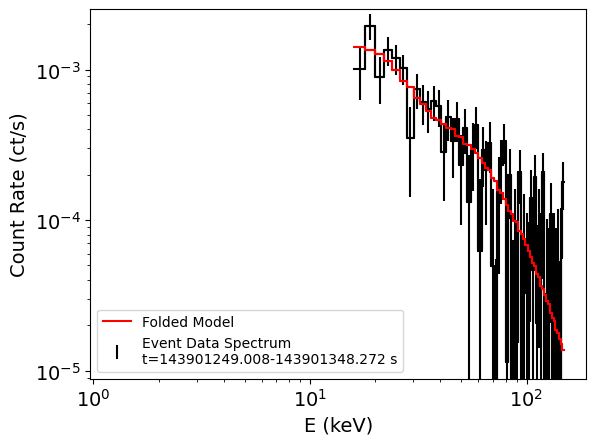

In [12]:
ba.fit_spectrum(spectrum_t90, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, use_cstat=False, fit_iterations=10000)

The fitted spectral model parameters can be obtained thorough the `spectral_model` attribute of the BatSpectrum object. 

In [13]:
spectrum_t90.spectral_model

{'parameters': {'Emin': {'val': 15.0,
   'lolim': 0.0,
   'hilim': 0.0,
   'errflag': 'FFFFFTFFF'},
  'Emax': {'val': 150.0, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'},
  'lg10Flux': {'val': -8.028400977457949,
   'lolim': -8.084642559437222,
   'hilim': -7.97764824390878,
   'errflag': 'FFFFFFFFF'},
  'PhoIndex': {'val': 1.8279132999060426,
   'lolim': 1.614052287211738,
   'hilim': 2.049449997999574,
   'errflag': 'FFFFFFFFF'},
  'norm': {'val': 0.001, 'lolim': 0.0, 'hilim': 0.0, 'errflag': 'FFFFFTFFF'}},
 'data': {'model_spectrum': <Quantity [1.41202013e-03, 1.34451285e-03, 1.26046897e-03, 1.14243505e-03,
             9.88838464e-04, 8.35172467e-04, 7.69336194e-04, 6.43651602e-04,
             5.91233956e-04, 5.33736641e-04, 4.73280221e-04, 4.64330796e-04,
             4.32686334e-04, 4.09698806e-04, 4.03884345e-04, 3.60606892e-04,
             3.55852329e-04, 3.19137949e-04, 3.15962301e-04, 2.97044773e-04,
             2.78770577e-04, 2.58079590e-04, 2.39797824e-04, 2.2193

Lets do a time resolved spectral analysis for each bayesian block time bin. This is simple to do as we can pass each timebin start and end time of our lightcurve to the `.create_pha` method. 

In [14]:
bayesian_spectra=event.create_pha(tstart=lc.tbins["TIME_START"], tstop=lc.tbins["TIME_STOP"])

Lets now fit a model to our spectra in parallel using the `ba.parallel.batspectrum_analysis` function (in order to not overload any users' computers while running this notebook we have set `nprocs=1` as a default which means parallelism is turned off). We fit all the spectra with a `cflux*po` model between 15-150 keV using the chi squared statistics. We set the default model parameters by passing in a dictionary to the `setPars` parameter, following the [pyXspec](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/model.html) documentation.  

In [15]:
output_bayesian_spectra=ba.parallel.batspectrum_analysis(bayesian_spectra, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, nprocs=1, use_cstat=False, fit_iterations=10000, recalc=True)


1 spectrum  in use
 
Spectral Data File: t_143900950.0-143901248.944_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -8.224e-04 +/- 1.204e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 298.9 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143900950.0-143901248.944_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                  513.12     using 80 bins.

Test statistic : Chi-Squared                  513.12     using 80 bins.
 Null hypothesis probability of 3.00e-65 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2  

With our spectral models in hand, lets plot the GRB's lightcurve and time resolved spectra. This is simple using the `plot_TTE_lightcurve` function. We can see that there is a single flux upper limit at the start of the GRB, due to the spectrum not being well fit. The remaining spectra are well fit and are in good agreement with the time resolved spectral fits shown in the [GRB catalog website for this burst](https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/web/GRB050724.html). 

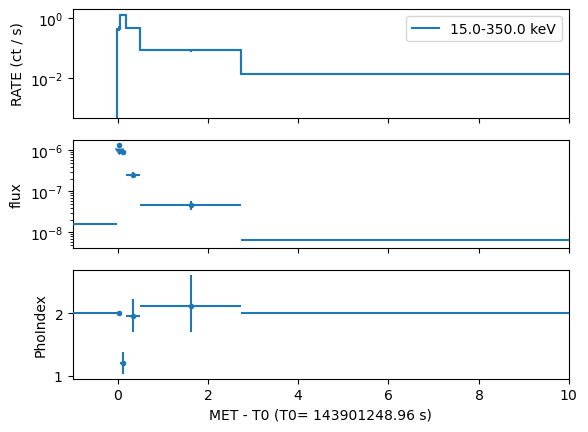

In [16]:
#ba.plot_TTE_lightcurve(lc, [spectrum_t90], plot_relative=True, T0=event.trigtime.met)
fig, ax = ba.plot_TTE_lightcurve(lc, output_bayesian_spectra, plot_relative=True, T0=event.trigtime.met)#, energy_range=None)
for i in ax:
    #i.set_xlim([-1,120])
    i.set_xlim([-1,10])
    
ax[0].set_yscale("log")

Since the spectral energy range for the BAT is relatively small, we are usually not able to constrain the spectral $E_\mathrm{pk}$. In order to get around this Sakamoto et al. (2009) devised a way to estimate $E_\mathrm{pk}$ from a BAT spectrum fitted with a power law, such as what we did above. Here, we use the method of Sakamoto et al. (2009) to obtain the spectral $E_\mathrm{pk}$ for our time resolved spectra. 

In [17]:
#calculate the estimated E_pk from Sakamoto+ 2009

def epk_estimator(spectra):
    all_data = ba.concatenate_spectrum_data(spectra, keys=["PhoIndex"])
    print(all_data)

    ep=np.ones(len(output_bayesian_spectra))
    ep_ll=np.ones_like(ep)
    ep_ul=np.ones_like(ep)


    ep=10**(3.258 - 0.829*all_data["PhoIndex"])
    ep_ll=10**(-20.684 + 43.646*all_data["PhoIndex"] - 26.891*all_data["PhoIndex"]**2 + 5.185*all_data["PhoIndex"]**3)
    ep_ul=10**(-5.198 + 16.568*all_data["PhoIndex"]-10.630*all_data["PhoIndex"]**2 + 2.034*all_data["PhoIndex"]**3)

    ep[np.isnan(all_data["PhoIndex_lolim"])]=np.nan

    print(ep)
    
    return ep,ep_ll, ep_ul

ep,ep_ll, ep_ul = epk_estimator(output_bayesian_spectra)
all_data = ba.concatenate_spectrum_data(output_bayesian_spectra, keys=["PhoIndex"])

{'PhoIndex': array([2.        , 2.        , 1.2114428 , 1.95320514, 2.12176279,
       2.01112211, 2.        ]), 'TIME_START': <Quantity [1.43900950e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901249e+08, 1.43901252e+08, 1.43901356e+08] s>, 'TIME_STOP': <Quantity [1.43901249e+08, 1.43901249e+08, 1.43901249e+08, 1.43901249e+08,
           1.43901252e+08, 1.43901356e+08, 1.43901552e+08] s>, 'PhoIndex_lolim': array([       nan,        nan, 0.17751626, 0.2565382 , 0.41798278,
       0.28046267,        nan]), 'PhoIndex_hilim': array([       nan,        nan, 0.17748675, 0.27376334, 0.4892528 ,
       0.29951775,        nan]), 'PhoIndex_upperlim': array([False, False, False, False, False, False, False])}
[         nan          nan 179.35517922  43.53042822  31.55430698
  38.97442976          nan]


Let's take a look at our bayesian blocked lightcurve, flux, spectral photon index, and estimated spectral $E_\mathrm{pk}$ all plotted together now. We can see that the spectra move from being hard during the peak of the GRB pulse to becoming significantly softer in the extended emission phase. 

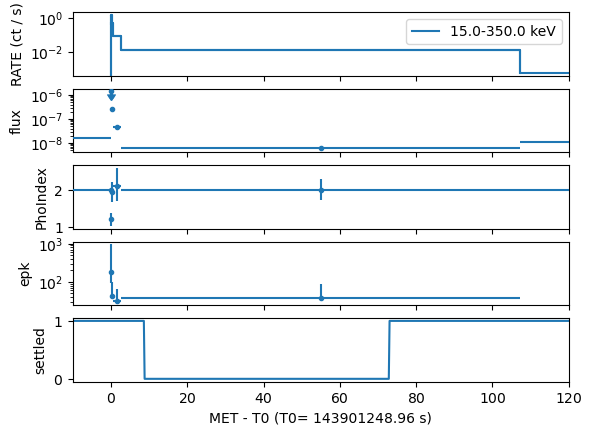

In [18]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = ba.plot_TTE_lightcurve(lc, output_bayesian_spectra, plot_relative=True, T0=event.trigtime.met, values=["flux", "phoindex", "epk", "settled"])#, energy_range=None)
for i in ax:
    i.set_xlim([-10,120])
    #i.set_xlim([-1,1])
    
ax[0].set_yscale("log")

tbin_cent=0.5*(all_data["TIME_START"].value+all_data["TIME_STOP"].value)-event.trigtime.met
tbin_err=0.5*(all_data["TIME_STOP"].value-all_data["TIME_START"].value)

ax[-2].errorbar(tbin_cent, ep, xerr=tbin_err, yerr=[ep_ll, ep_ul], linestyle="None", marker="o", markersize=3, color=colors[0])
ax[-2].set_yscale("log")


ax[-1].plot(event.attitude.time.value - event.trigtime.met, event.attitude.is_settled, color=colors[0])
#axis.set_xlim([0,150])

Lets now take a look at some of the other lightcurves and quantities that we can compare to the BAT refined analysis webpage. Below, we construct a 1 second binned lightcurve and show the different energy bins which can also be found on the GRB catalog website.  

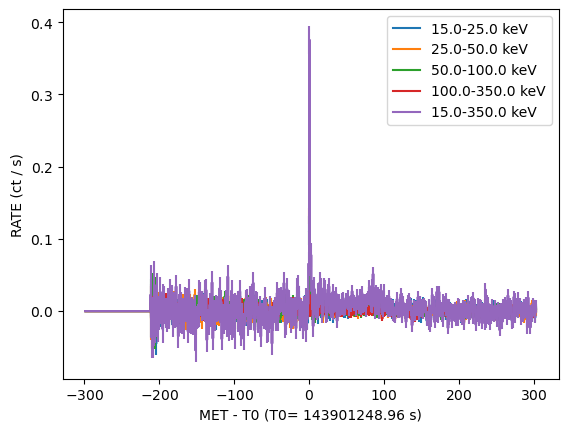

In [19]:
lc_1s=event.create_lightcurve(timebinalg="uniform", timedelta=np.timedelta64(1, "s"))
fig, ax =lc_1s.plot(T0=event.trigtime.met, plot_relative=True)

We can once again easily plot the $T_{90}$ interval on top of the plot of the 1 second binned lightcurve. 

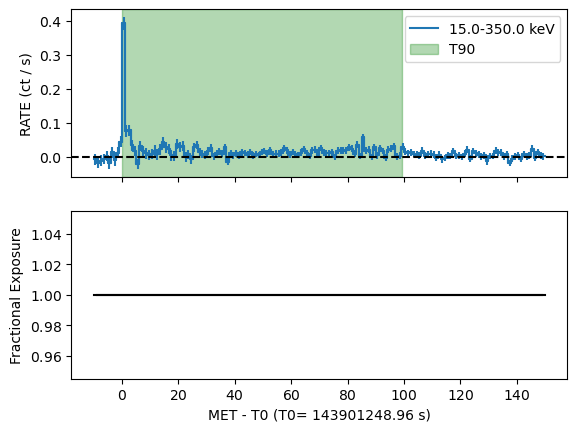

In [20]:
lc_1s.set_timebins(tmin=-10*u.s, tmax=150*u.s, timedelta=np.timedelta64(1, "s"), is_relative=True, T0=event.trigtime.met)
fig, ax =lc_1s.plot(energybins=[15,350]*u.keV, T0=event.trigtime.met, plot_relative=True, plot_exposure_fraction=True)
ax[0].axhline(0, c='k', ls='--')

ax[0].axvspan((lc.tdurs['T90']['TSTART']-event.trigtime.met*u.s).value, (lc.tdurs['T90']['TSTOP']-event.trigtime.met*u.s).value, color='g', alpha=0.3, label="T90")
ax[0].legend()


Another comparison that we can make is in the peak spectral fit and flux. Lets start by constructing our spectrum for this time interval and plotting it. 

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

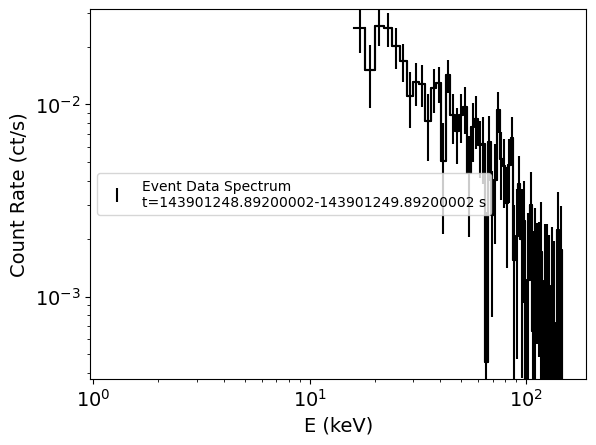

In [21]:
spectrum_peak_1s=event.create_pha(tstart=lc.tdurs['PEAK']['TSTART'], tstop=lc.tdurs['PEAK']['TSTOP'])
spectrum_peak_1s.plot()

Now, lets fit it. Using the default `cflux*po` model. 

We will see that our fitted photon index will be 1.639 which is in agreement with what was previously found (see the "1-s peak spectral analysis" near the top of the [webpage](https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/web/GRB050724.html) with the "PL" model and a "Ph_index" of -1.658). Note the negative sign that is missing in our pyXspec fit, which is implied. 


1 spectrum  in use
 
Spectral Data File: t_143901248.89200002-143901249.89200002_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.259e-01 +/- 3.243e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 1 sec
 Using fit statistic: cstat
 Using Response (RMF) File            t_143901248.89200002-143901249.89200002_80chan.rsp for Source 1


Fit statistic  : C-Statistic                    1.84     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                  404.96     using 80 bins.
 Null hypothesis probability of 2.75e-45 with 79 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux

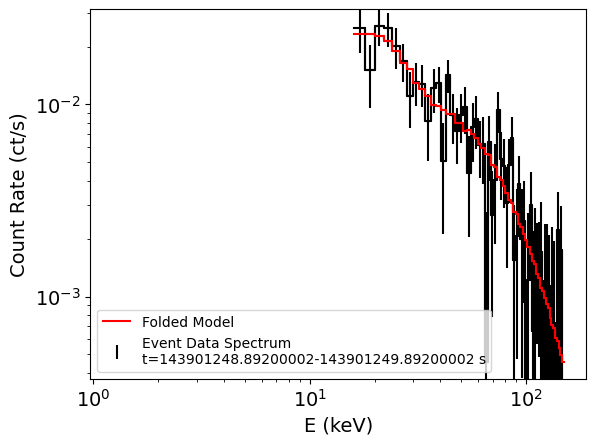

In [22]:
ba.fit_spectrum(spectrum_peak_1s, use_cstat=False)

We can also get a sense of the number of photons that were detected in each energy bin for the peak 1 second time interval. This is what our calculation here shows. 

In [23]:
peak_flux = event.create_lightcurve(tstart=lc.tdurs['PEAK']['TSTART'],tstop=lc.tdurs['PEAK']['TSTOP'], timedelta=np.timedelta64(0, "s"))
print(peak_flux.data["RATE"]*(lc.tdurs['PEAK']['TSTOP']-lc.tdurs['PEAK']['TSTART']))


[[0.1196039  0.13763913 0.10381171 0.02115031 0.38220506]] ct


Now, lets make similar comparisons to the total time average spectral parameters that are shown on the [GRB catalog's website](https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/web/GRB050724.html) for this burst. In creating our spectrum and fitting it below, we find that the fitted photon index of 1.9 is in agreement with the BAT team's prior analysis, finding "Ph_index"=-1.934 for the powerlaw that was fit in the "Time-averaged spectral analysis" section. Additionally, the fluence obtained from our spectral fit calculated as $T_\mathrm{tot} * F_\mathrm{tot} = 107.164 \mathrm{s}\ *10^{-8.04161} \ \mathrm{erg/s/cm}^2 = 9.74 *10^{-7} \  \mathrm{ erg/cm}^2$ with the fitted $1\sigma$ error is in agreement with the $1.01 *10^{-6} \  \mathrm{ erg/cm}^2$ figure that is quoted for the same powerlaw fit in the 15-150 keV energy band. 


1 spectrum  in use
 
Spectral Data File: t_143901248.944-143901356.144_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.067e-02 +/- 1.933e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 107.2 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143901248.944-143901356.144_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                146916.3     using 80 bins.

Test statistic : Chi-Squared                146916.3     using 80 bins.
 Null hypothesis probability of 0.0e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2

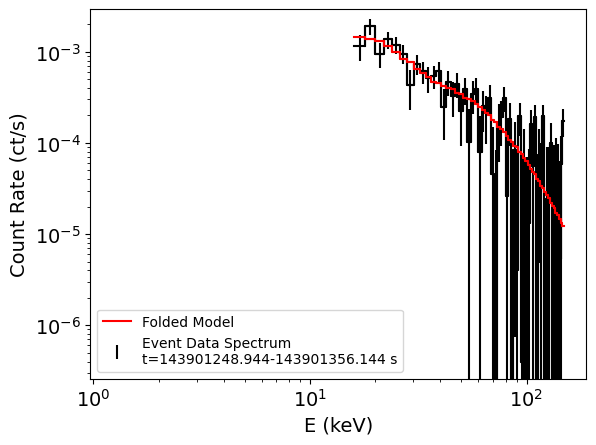

In [24]:
spectrum_peak_tot=event.create_pha(tstart=lc.tdurs['TOT']['TSTART'], tstop=lc.tdurs['TOT']['TSTOP'])
ba.fit_spectrum(spectrum_peak_tot, use_cstat=False)


Similar to the 1 second peak flux, we can also calculate the $T_{100}$ fluence in each energy band by rebinning our lightcurve into a single timebin extending from the start to the end of the time interval. 

In [25]:
total_fluence = event.create_lightcurve(tstart=lc.tdurs['TOT']['TSTART'], tstop=lc.tdurs['TOT']['TSTOP'], timedelta=np.timedelta64(0, "s"))
print(total_fluence.data["RATE"]*(lc.tdurs['TOT']['TSTOP']-lc.tdurs['TOT']['TSTART']))

[[0.76122338 0.71934947 0.35463966 0.14356256 1.97877507]] ct


Finally, we show an eample where we attempt to fit a Band spectrum to the GRB and show that we get unconstrained fits on many parameters which is not useful by itself but if a Band function is used in fitting spectra from BAT and other instruments then this becomes feasible.  


1 spectrum  in use
 
Spectral Data File: t_143901248.944-143901356.144_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.067e-02 +/- 1.933e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 107.2 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_143901248.944-143901356.144_80chan.rsp for Source 1


Fit statistic  : Chi-Squared                   98.12     using 80 bins.

Test statistic : Chi-Squared                   98.12     using 80 bins.
 Null hypothesis probability of 6.15e-02 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*grbm<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   

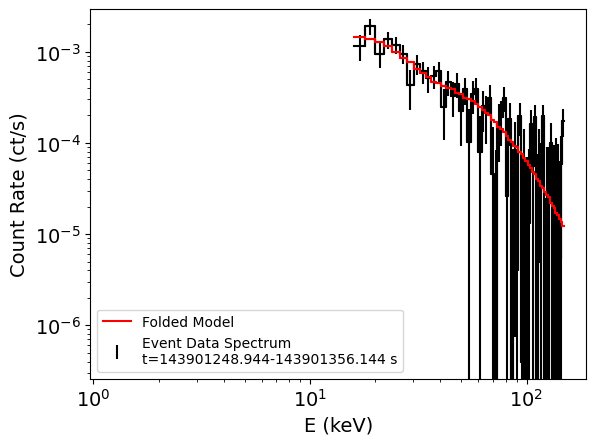

In [26]:
ba.fit_spectrum(spectrum_peak_tot, use_cstat=False, generic_model="cflux*grbm", setPars={1:"15,-1", 2:"150,-1",3:-8, 4:"-2",5:"-2",6:100, 7:"1e-3,-1"}, fit_iterations=10000)

Now, with out different quantities obtained, lets create our plots that are found in the paper associated with the BatAnalysis TTE data analysis capabilities. First, we will plot the $T_{90}$ spectrum and the spectral fit as well as the differences with respect to the GRB catalog's $T_{90}$ spectrum for this same GRB.

First, we start with getting the $T_{90}$ spectrum from the BAT Teams's GRB catalog.

In [27]:
import requests as reqs
from bs4 import BeautifulSoup as bso

#base_url="https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/data_product/remake_spec/spec_time_resolved/"
base_url="https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/data_product/00147478000-results/pha/"
site=reqs.get(base_url)
mysoup = bso(site.text, 'html.parser')
pha_filename="sw00147478000b_t90.pha"

catalog_pha_file=reqs.get(base_url+pha_filename)
with open(ba.datadir().joinpath(pha_filename), 'wb') as f:
    f.write(catalog_pha_file.content)

#load the downloaded spectrum file
grbcat_spect=ba.Spectrum.from_file(ba.datadir().joinpath(pha_filename))


/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No event file has been specified. The resulting spectrum object will not be able to bemodified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No detector quality mask file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No auxiliary ray tracing file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.


Now, we can plot the T$_{90}$ spectrum and the spectral fit as well. Note that this fit does not use a time averaged DRM as is not as accurate as it could be. Nonetheless, we will see that the fit that uses the time averaged DRM further below is in agreement with what is found here. 

<>:27: SyntaxWarning: invalid escape sequence '\G'
<>:27: SyntaxWarning: invalid escape sequence '\G'
/var/folders/vs/mk2m3n7d5650zxfytqb8_ypw8nkvkq/T/ipykernel_53791/84761843.py:27: SyntaxWarning: invalid escape sequence '\G'


1.8279132999060426 [1.61405229 2.04945   ] [0.21386101 0.2215367 ]


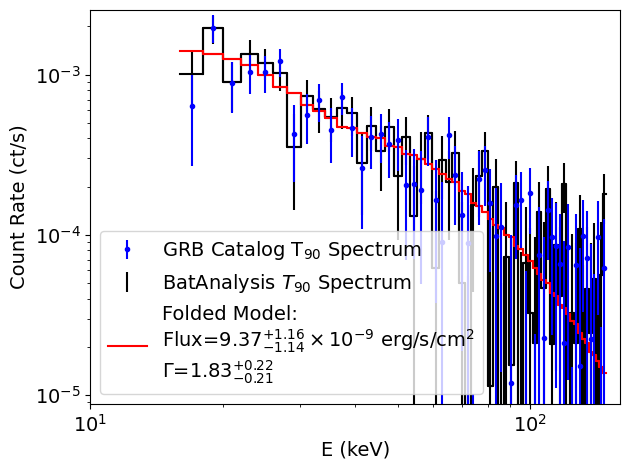

In [28]:
fig, ax = spectrum_t90.plot()

# get the fitted model info
flux = 10 ** spectrum_t90.spectral_model['parameters']["lg10Flux"]["val"]
flux_err = 10 ** np.array(
    [
        spectrum_t90.spectral_model['parameters']["lg10Flux"]["lolim"],
        spectrum_t90.spectral_model['parameters']["lg10Flux"]["hilim"],
    ]
)
flux_diff = np.abs(flux - flux_err)


phoindex = spectrum_t90.spectral_model['parameters']["PhoIndex"]["val"]
phoindex_err = np.array(
    [
        spectrum_t90.spectral_model['parameters']["PhoIndex"]["lolim"],
        spectrum_t90.spectral_model['parameters']["PhoIndex"]["hilim"],
    ]
)
phoindex_diff = np.abs(phoindex - phoindex_err)
print(phoindex, phoindex_err, phoindex_diff)


folded_model_label = (
    f"Folded Model:\nFlux={flux/1e-9:-.3}$^{{{flux_diff[1]/1e-9:+.3}}}_{{{-1*flux_diff[0]/1e-9:+.3}}} \\times 10^{{-9}}$ erg/s/cm$^2$"
    + f"\n$\Gamma$={phoindex:-.3}$^{{{phoindex_diff[1]:+.2}}}_{{{-1*phoindex_diff[0]:+.2}}}$"
)
data_label=r"BatAnalysis $T_{90}$ Spectrum"


#set the xlimit
ax.set_xlim([10,160])

#plot the catalog T90 pha file
ecen = 0.5 * (grbcat_spect.ebins["E_MIN"] + grbcat_spect.ebins["E_MAX"])
tot_error = np.sqrt(grbcat_spect.data["STAT_ERR"].value ** 2 + grbcat_spect.data["SYS_ERR"].value ** 2)
energy_idx = np.where((grbcat_spect.ebins["E_MIN"] >= 15*u.keV) & (grbcat_spect.ebins["E_MAX"] < 150*u.keV))

#ax.loglog(grbcat_spect.ebins["E_MIN"][energy_idx], grbcat_spect.data["RATE"][energy_idx], color="b", drawstyle="steps-post", ls="--")
#ax.loglog(grbcat_spect.ebins["E_MAX"][energy_idx], grbcat_spect.data["RATE"][energy_idx], color="b", drawstyle="steps-pre", ls="--")
ax.errorbar(
    ecen[energy_idx],
    grbcat_spect.data["RATE"][energy_idx],
    yerr=tot_error[energy_idx] * grbcat_spect.data["RATE"].unit,
    color="b",
    marker=".",
    ls="None",
    label=r"GRB Catalog T$_{90}$ Spectrum", zorder=5, alpha=1
)

#get the preset line handles
labels=ax.get_legend_handles_labels()

#set the new legend labels for the handles
leg = ax.legend(handles=labels[0][::-1],labels=[folded_model_label,data_label, labels[1][-1]][::-1], fontsize=14)
leg.set_zorder(10)


fig.tight_layout()
fig.savefig(f'{event.result_dir.joinpath("t90_spectrum.pdf")}')

Lets now make the plot for the lightcurve and the time resolved spectra. We start off by getting the GRB catalog's time resolved spectra and responses for us to fit with a `cflux*po` model to have identical comparisons to what we do for our time resolved spectra. 

['resolved_spec_2/', 'resolved_spec_3/', 'resolved_spec_4/', 'resolved_spec_5/']
[143901248.976, 143901249.18]


/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No event file has been specified. The resulting spectrum object will not be able to bemodified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No detector quality mask file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No auxiliary ray tracing file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.



1 spectrum  in use
 
Spectral Data File: sw00147478000b_avg.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.197e+00 +/- 7.173e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 0.204 sec
 Using fit statistic: chi
 Using Response (RMF) File            sw00147478000b_avg.rsp for Source 1


Fit statistic  : Chi-Squared                  428.61     using 80 bins.

Test statistic : Chi-Squared                  428.61     using 80 bins.
 Null hypothesis probability of 1.32e-50 with 76 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No event file has been specified. The resulting spectrum object will not be able to bemodified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No detector quality mask file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No auxiliary ray tracing file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.



1 spectrum  in use
 
Spectral Data File: sw00147478000b_avg.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.080e-01 +/- 5.625e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 0.236 sec
 Using fit statistic: chi
 Using Response (RMF) File            sw00147478000b_avg.rsp for Source 1


Fit statistic  : Chi-Squared                  468.30     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number: 1

Test statistic : Chi-Squared                  468.30     using 80 bins.

***Warning: Chi-square may not be valid due to bins with zero variance
            in spectrum number(s): 1 

 Null hypothesis probability of 5.11e-57 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin 

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No event file has been specified. The resulting spectrum object will not be able to bemodified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No detector quality mask file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No auxiliary ray tracing file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.



1 spectrum  in use
 
Spectral Data File: sw00147478000b_avg.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.685e-01 +/- 3.181e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 0.868 sec
 Using fit statistic: chi
 Using Response (RMF) File            sw00147478000b_avg.rsp for Source 1


Fit statistic  : Chi-Squared                  388.73     using 80 bins.

Test statistic : Chi-Squared                  388.73     using 80 bins.
 Null hypothesis probability of 8.52e-43 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1

/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No event file has been specified. The resulting spectrum object will not be able to bemodified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No detector quality mask file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.
/Users/tparsota/miniforge3/lib/python3.12/site-packages/astropy/units/decorators.py:316: UserWarning: No auxiliary ray tracing file has been specified. The resulting spectrum object will not be able to be modified either by rebinning in energy or time.



1 spectrum  in use
 
Spectral Data File: sw00147478000b_avg.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.551e-02 +/- 1.708e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 105.9 sec
 Using fit statistic: chi
 Using Response (RMF) File            sw00147478000b_avg.rsp for Source 1


Fit statistic  : Chi-Squared                18405.98     using 80 bins.

Test statistic : Chi-Squared                18405.98     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1

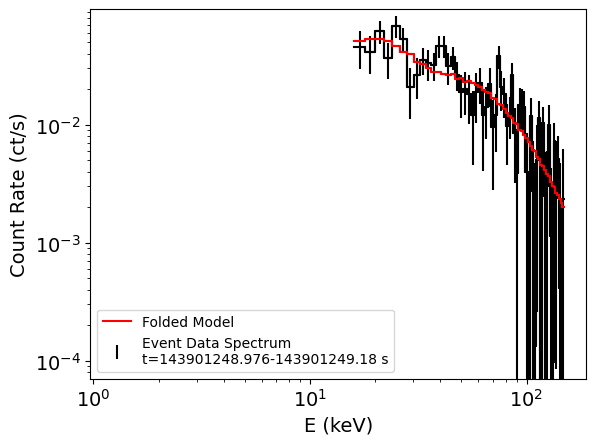

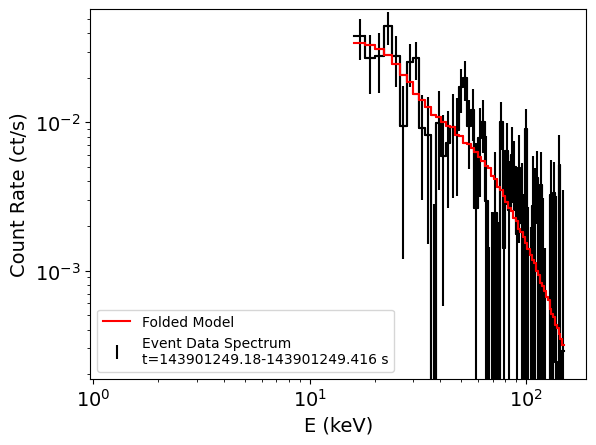

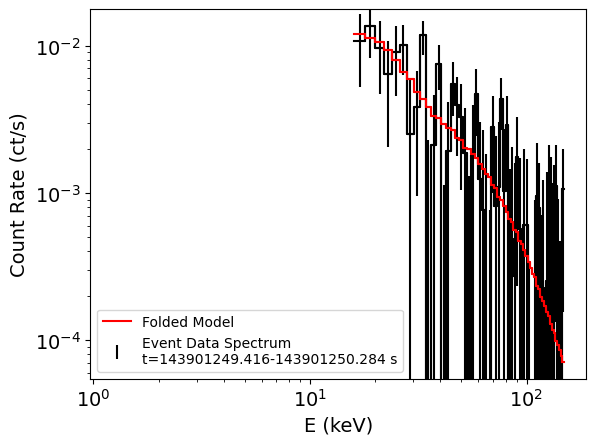

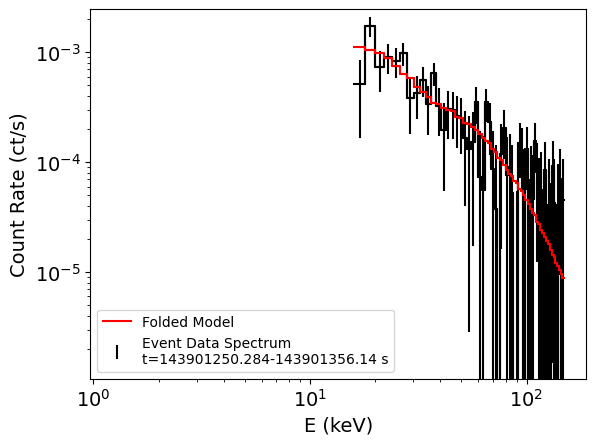

In [29]:
base_url="https://swift.gsfc.nasa.gov/results/batgrbcat/GRB050724/data_product/remake_spec/spec_time_resolved/"
site=reqs.get(base_url)
mysoup = bso(site.text, 'html.parser')

#get the list of time resolved spectra directories
resolve_spec_dir=[i.text for i in mysoup.select("body a") if "resolved_spec" in i.text and ".txt" not in i.text]
print(resolve_spec_dir)

#iterate through each and get the pha/rsp file and the timestart/end of the spectrum
grbcat_tresolved_spectra=[]
for i in resolve_spec_dir:
    site=reqs.get(base_url+i)
    specsoup = bso(site.text, 'html.parser')
    spect_files=specsoup.select("body a")
    
    #get the spectrum time info
    time_info=reqs.get(base_url+i+"spectrum_times.txt")
    if len(time_info.text.splitlines())==2:
        times=[float(i) for i in time_info.text.splitlines()[1].split()[-2:]]
    else:
        times=[float(i) for i in [time_info.text.splitlines()[1].split()[-2], time_info.text.splitlines()[-1].split()[-1]]]

    print(times)
    
    #get the pha and rsp files
    pha_filename=[i.text for i in spect_files if "_avg.pha" in i.text][0]
    rsp_filename=[i.text for i in spect_files if "_avg.rsp" in i.text][0]
    
    pha_file=reqs.get(base_url+i+pha_filename)
    rsp_file=reqs.get(base_url+i+rsp_filename)
    
    with open(ba.datadir().joinpath(pha_filename), 'wb') as f:
        f.write(pha_file.content)
    with open(ba.datadir().joinpath(rsp_filename), 'wb') as f:
        f.write(rsp_file.content)
        
    #load the downloaded spectrum file
    grbcat_spect=ba.Spectrum.from_file(ba.datadir().joinpath(pha_filename))

    #do the spectral fitting to get the spectral fitted parameters
    ba.fit_spectrum(grbcat_spect, use_cstat=False, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, fit_iterations=10000)

    #print(grbcat_spect.spectral_model)

    grbcat_tresolved_spectra.append(grbcat_spect)

spect_data = ba.concatenate_spectrum_data(grbcat_tresolved_spectra, ["lg10flux", "phoindex"])

print(spect_data)

    

Now, we can plot all the comparisons side by side. The values for the GRB catalog's T$_{90}$ are taken from the webpage directly. 

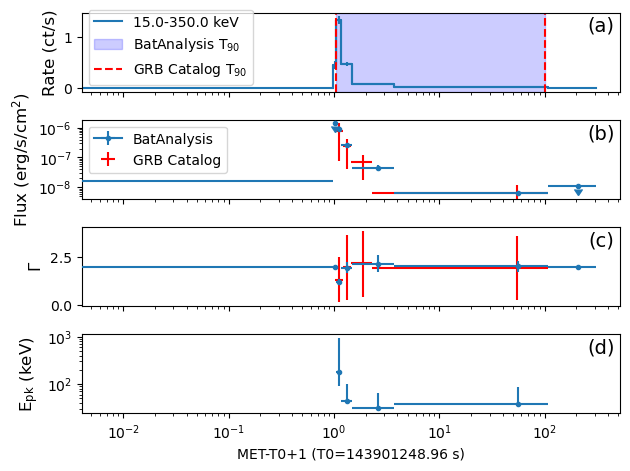

In [30]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

offset=event.trigtime.met-1

fig, ax = ba.plot_TTE_lightcurve(lc, output_bayesian_spectra, plot_relative=True, T0=offset, values=["flux", "phoindex", "epk"])#, energy_range=None)
#for i in ax:
    #i.set_xlim([-10,120])
    #i.set_xlim([-1,1])
    
ax[0].set_xscale("log")

#plot the T90 region
ax[0].axvspan((lc.tdurs['T90']['TSTART']-offset*u.s).value, (lc.tdurs['T90']['TSTOP']-offset*u.s).value, color='b', alpha=0.2, label=r"BatAnalysis T$_{90}$")
ax[0].axvline((0.052+event.trigtime.met-offset), color='r', ls='--', alpha=1, label=r"GRB Catalog T$_{90}$")
ax[0].axvline((98.736+event.trigtime.met-offset), color='r', ls='--', alpha=1)

ax[0].legend()

#plot the e peak estimates
tbin_cent=0.5*(all_data["TIME_START"].value+all_data["TIME_STOP"].value)-offset
tbin_err=0.5*(all_data["TIME_STOP"].value-all_data["TIME_START"].value)

ax[-1].errorbar(tbin_cent, ep, xerr=tbin_err, yerr=[ep_ll, ep_ul], linestyle="None", marker="o", markersize=3, color=colors[0])
ax[-1].set_yscale("log")

#modify the ylabels and xlabel
ax[0].set_ylabel("Rate (ct/s)", fontsize=12)
ax[1].set_ylabel("Flux (erg/s/cm$^2$)", fontsize=12)
ax[2].set_ylabel(r"$\Gamma$", fontsize=12)
ax[3].set_ylabel(r"$\mathrm{E}_\mathrm{pk}$ (keV)", fontsize=12)
ax[3].set_xlabel(f"MET-T0+1 (T0={(event.trigtime.met)*u.s})")

#get the spectral paramters that were plotted so we can add a label
children = ax[1].get_children()[0]
batanalysis_color=children.get_color()
ax[1].errorbar(tbin_cent, np.nan*np.ones_like(tbin_cent), xerr=np.ones_like(tbin_cent),yerr=np.ones_like(tbin_cent),  color=batanalysis_color, label="BatAnalysis", marker=".")

#now plot the results of the GRB catalog time resolved spectra
tbin_cent=0.5*(spect_data["TIME_START"].value+spect_data["TIME_STOP"].value)-offset
tbin_err=0.5*(spect_data["TIME_STOP"].value-spect_data["TIME_START"].value)
ax[1].errorbar(tbin_cent, spect_data['lg10flux'], xerr=tbin_err, \
               yerr=np.abs([spect_data['lg10flux']-spect_data['lg10flux_lolim'], spect_data['lg10flux_hilim']-spect_data['lg10flux']]),
              label="GRB Catalog", color="r", ls="None")

ax[2].errorbar(tbin_cent, spect_data['phoindex'], xerr=tbin_err, \
               yerr=np.abs([spect_data['phoindex']-spect_data['phoindex_lolim'], spect_data['phoindex_hilim']-spect_data['phoindex']]),
              label="GRB Catalog", color="r", ls="None")

ax[1].legend()

for a, l in zip(ax, ["a", "b", "c", "d"]):
    a.text(
        0.99, 0.95, f"({l})", ha="right", va="top", transform=a.transAxes, fontsize=14
    )


fig.tight_layout()
fig.savefig(f'{event.result_dir.joinpath("lightcurve_t_resolved_parameters.pdf")}')

We can also construct a time averaged DRM, where different DRMs are added and weighted by the total counts for the timebin that the DRM was constructed within. We can use this to refit our $T_{90}$ spectrum and see how the fitted parameters may change. 

/private/tmp/batdata/download_examples/00147478000_eventresult/pha/t_143901249.008-143901348.272_80chan.pha


(<Axes: xlabel='E_IN [keV]', ylabel='E_OUT [keV]'>,
 <matplotlib.collections.QuadMesh at 0x3e8ed8d10>)

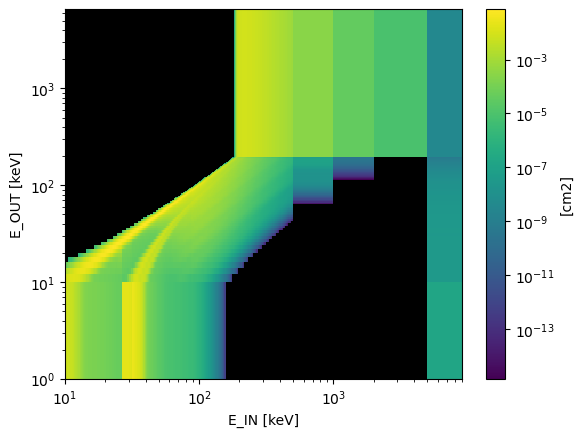

In [31]:
print(spectrum_t90.pha_file)
avg_drm=ba.BatDRM.concatenate([i.drm for i in output_bayesian_spectra], weights=lc.data["TOTCOUNTS"]/np.sum(lc.data["TOTCOUNTS"]), drm_save_file=spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp"))
avg_drm.plot()

We set our spectrum to use the averaged DRM that we have created and then we can fit it to obtain the new spectral parameters. 


1 spectrum  in use
 
Spectral Data File: t_143901249.008-143901348.272_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.080e-02 +/- 2.110e-03
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 99.26 sec
 Using fit statistic: chi
 Using Response (RMF) File            avg_drm.rsp for Source 1


Fit statistic  : Chi-Squared                  119.51     using 80 bins.

Test statistic : Chi-Squared                  119.51     using 80 bins.
 Null hypothesis probability of 1.75e-03 with 78 degrees of freedom
 Current data and model not fit yet.

Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex      

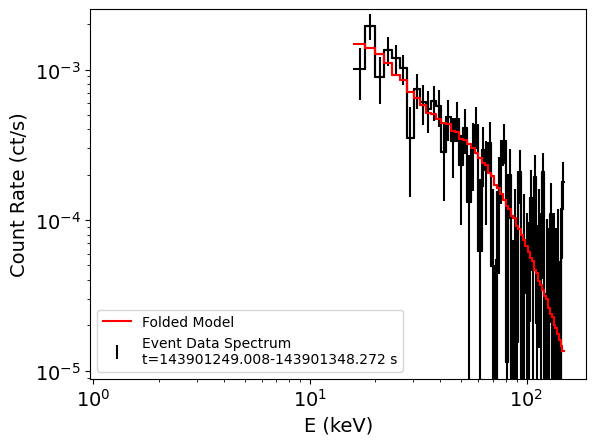

In [32]:
spectrum_t90.drm_file=spectrum_t90.pha_file.parent.joinpath("avg_drm.rsp")

ba.fit_spectrum(spectrum_t90, generic_model="cflux*po", setPars={1:"15,-1", 2:"150,-1",3:-9, 4:"-1",5:".001,-1"}, use_cstat=False, fit_iterations=10000)


Lets now remake our plot above with the new spectral fit.

<>:25: SyntaxWarning: invalid escape sequence '\G'
<>:25: SyntaxWarning: invalid escape sequence '\G'
/var/folders/vs/mk2m3n7d5650zxfytqb8_ypw8nkvkq/T/ipykernel_53791/3157728857.py:25: SyntaxWarning: invalid escape sequence '\G'


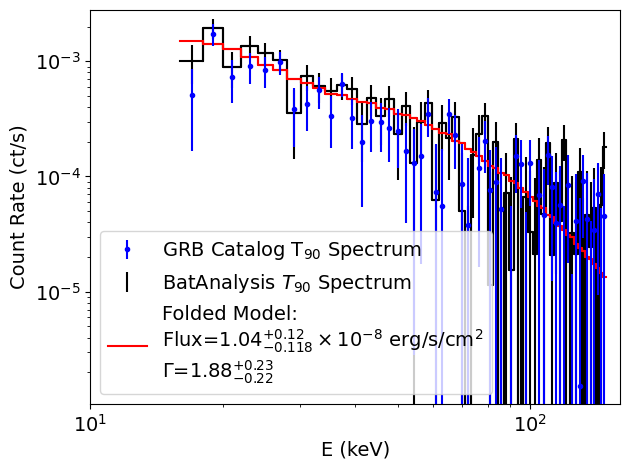

In [34]:

fig, ax = spectrum_t90.plot()

# get the fitted model info
flux = 10 ** spectrum_t90.spectral_model['parameters']["lg10Flux"]["val"]
flux_err = 10 ** np.array(
    [
        spectrum_t90.spectral_model['parameters']["lg10Flux"]["lolim"],
        spectrum_t90.spectral_model['parameters']["lg10Flux"]["hilim"],
    ]
)
flux_diff = np.abs(flux - flux_err)


phoindex = spectrum_t90.spectral_model['parameters']["PhoIndex"]["val"]
phoindex_err = np.array(
    [
        spectrum_t90.spectral_model['parameters']["PhoIndex"]["lolim"],
        spectrum_t90.spectral_model['parameters']["PhoIndex"]["hilim"],
    ]
)
phoindex_diff = np.abs(phoindex - phoindex_err)

folded_model_label = (
    f"Folded Model:\nFlux={flux/1e-8:-.3}$^{{{flux_diff[1]/1e-8:+.3}}}_{{{-1*flux_diff[0]/1e-8:+.3}}} \\times 10^{{-8}}$ erg/s/cm$^2$"
    + f"\n$\Gamma$={phoindex:-.3}$^{{{phoindex_diff[1]:+.2}}}_{{{-1*phoindex_diff[0]:+.2}}}$"
)
data_label=r"BatAnalysis $T_{90}$ Spectrum"


#set the xlimit
ax.set_xlim([10,160])

#plot the catalog T90 pha file
ecen = 0.5 * (grbcat_spect.ebins["E_MIN"] + grbcat_spect.ebins["E_MAX"])
tot_error = np.sqrt(grbcat_spect.data["STAT_ERR"].value ** 2 + grbcat_spect.data["SYS_ERR"].value ** 2)
energy_idx = np.where((grbcat_spect.ebins["E_MIN"] >= 15*u.keV) & (grbcat_spect.ebins["E_MAX"] < 150*u.keV))

#ax.loglog(grbcat_spect.ebins["E_MIN"][energy_idx], grbcat_spect.data["RATE"][energy_idx], color="b", drawstyle="steps-post", ls="--")
#ax.loglog(grbcat_spect.ebins["E_MAX"][energy_idx], grbcat_spect.data["RATE"][energy_idx], color="b", drawstyle="steps-pre", ls="--")
ax.errorbar(
    ecen[energy_idx],
    grbcat_spect.data["RATE"][energy_idx],
    yerr=tot_error[energy_idx] * grbcat_spect.data["RATE"].unit,
    color="b",
    marker=".",
    ls="None",
    label=r"GRB Catalog T$_{90}$ Spectrum", zorder=5, alpha=1
)

#get the preset line handles
labels=ax.get_legend_handles_labels()

#set the new legend labels for the handles
leg = ax.legend(handles=labels[0][::-1],labels=[folded_model_label,data_label, labels[1][-1]][::-1], fontsize=14)
leg.set_zorder(10)


fig.tight_layout()
fig.savefig(f'{event.result_dir.joinpath("t90_spectrum.pdf")}')